## Import modules

In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import sys
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
sys.path.append("./src")

import matplotlib
import matplotlib.ticker as mtick
import itertools
import json
import dataframe_image as dfi
from PIL import Image

from importlib import reload
import src.cathay_db as db
import src.utils as ut
import src.financial_statement as fs
reload(ut)
reload(fs)

# set max display rows
pd.set_option("display.max_rows", 200)
# set max display columns
pd.set_option("display.max_columns", 100)
# Set the float format to display without scientific notation
pd.options.display.float_format = '{:.4f}'.format
# Set global font to 'Microsoft JhengHei'
matplotlib.rcParams['font.sans-serif'] = ['Microsoft JhengHei']


# Define Params

In [2]:
REB_MONTH = [2, 5, 7, 11]

CAP_TOP = 50
CAP_BOT = 200
AMOUNT_FLOOR = 40
N = 40
TURNOVER = 0
TILTED_NUM = 0.475
TILTED = 0.4
FACTOR_WEIGHT = 1
LDY_WEIGHT = 1
D1Y_WEIGHT = 1
NUM_CUT = 5
WEIGHT_BY_YIELDS = False

TURNOVER_DICT = {
    "2": 10,
    "3": 10,
    "5": 30,
    "7": 30,
    "11": 10,
}

SORTING_DICT = {
    "2": "rank_sum_average",
    "3": "rank_sum_average",
    "5": "rank_sum_dividends",
    "7": "rank_sum_dividends",
    "11": "rank_sum_average",
}

WEIGHTING_DICT = {
    "2": "rank_sum_average",
    "3": "rank_sum_average",
    "5": "rank_sum_dividends",
    "7": "rank_sum_dividends",
    "11": "rank_sum_average",
}

ADJUST_WEIGHTS_PARAMS = {
    "adjust_type": ["triangle", "triangle"],
    "ratio": TILTED_NUM,
    "weight_ratio": TILTED,
    "rank_col": WEIGHTING_DICT,
    "weight_col": "weight",
}

# save upper params to json


## Define functions

In [3]:
def create_table(df, cell_heights):
    fig, ax = plt.subplots()
    formatted_data = df.round(2).values.tolist()
    labels = df.columns.tolist()

    table = ax.table(
        cellText=formatted_data,
        colLabels=labels,
        colWidths=[0.5] * len(labels),
        loc="center",
    )

    cell_dict = table.get_celld()
    for i, label in enumerate(labels):
        cell_dict[(0, i)].set_height(cell_heights[0])
        for j in range(1, len(formatted_data) + 1):
            cell_dict[(j, i)].set_height(cell_heights[1])

    table.set_fontsize(25)
    ax.axis("off")

    return fig, ax


def top_n(
    df, n=5, columns=["last_dividend_yield", "predict_rank"], ascending=[False, True]
):
    return df.sort_values(by=columns, ascending=ascending).head(n)


def get_daily_portfolio(
    df_rebalance,
    reb_lst,
    df_price,
    weight_type="vw",
    adjust_type=["equal", "equal"],
    ratio: float = 0.5,
    weight_ratio: int = 1,
    rank_col: str = "rank",
    weight_col: str = "weight",
    weight_by_yields=False,
    replace_bottom="min",
):
    df_portfolio_value_all = pd.DataFrame([])
    df_portfolio_detail_start = pd.DataFrame([])
    df_portfolio_detail_end = pd.DataFrame([])
    df_portfolio_detail_all = pd.DataFrame([])
    portfolio_quarterly_return = []
    portfolio_value = 1000000000

    for i in range(len(reb_lst) - 1):
        df_portfolio = df_rebalance.copy()

        df_portfolio_copy = df_portfolio[df_portfolio["date"] == reb_lst[i]].copy()
        df_portfolio_copy["weight"] = 1 / df_portfolio_copy.groupby("date")[
            "ticker"
        ].transform("count")
        df_portfolio_copy = ut.adjust_weights(
            df_portfolio_copy, adjust_type, ratio, weight_ratio, rank_col, weight_col
        )

        if weight_by_yields:
            if replace_bottom == "min":
                df_portfolio_copy = ut.weight_by_yields(
                    df_portfolio_copy, 5, "adjusted_weight", "min"
                )
            if replace_bottom == "q20":
                df_portfolio_copy = ut.weight_by_yields(
                    df_portfolio_copy, 5, "adjusted_weight", "q20"
                )

            use_weight_col = "weight_by_yields"
        else:
            use_weight_col = "adjusted_weight"

        df_portfolio_copy.sort_values("ticker", inplace=True)
        ticker_list = df_portfolio_copy["ticker"].unique()

        if weight_type == "ew":
            if len(df_portfolio_value_all) == 0:
                df_portfolio_copy["portfolio_value"] = portfolio_value / len(
                    ticker_list
                )
            else:
                df_portfolio_copy["portfolio_value"] = df_portfolio_value_all[
                    "portfolio_value"
                ].iloc[-1] / len(ticker_list)

        if weight_type == "vw":
            if len(df_portfolio_value_all) == 0:
                df_portfolio_copy["portfolio_value"] = (
                    portfolio_value * df_portfolio_copy[use_weight_col]
                )
            else:
                df_portfolio_copy["portfolio_value"] = (
                    df_portfolio_value_all["portfolio_value"].iloc[-1]
                    * df_portfolio_copy[use_weight_col]
                )

        df_portfolio_copy.reset_index(drop=True, inplace=True)
        # give the weight to each stock by market cap
        # df_portfolio_copy['portfolio_value'] = df_portfolio_copy['portfolio_value'] * df_portfolio_copy['market_cap'] / df_portfolio_copy['market_cap'].sum()

        df_price_period = df_price[
            (df_price["ticker"].isin(ticker_list))
            & (df_price["date"] >= reb_lst[i])
            & (df_price["date"] <= reb_lst[i + 1])
        ].copy()
        # check if there is price missing

        if (
            df_price_period.groupby("ticker")["date"].count().max()
            != df_price_period.groupby("ticker")["date"].count().min()
        ):
            print("fuck")

        df_price_period.sort_values(["ticker", "date"], inplace=True)
        df_price_period.reset_index(drop=True, inplace=True)
        df_price_period["price_shift"] = df_price_period.groupby("ticker")[
            "price"
        ].shift(1)
        df_price_period["rt"] = (
            df_price_period["price"] / df_price_period["price_shift"]
        )
        df_price_period["rt"].fillna(1, inplace=True)
        # pivot the rt
        df_rt_pivot = df_price_period.pivot(
            index="date", columns="ticker", values="rt"
        ).copy()

        df_portfolio_value = (
            df_rt_pivot.cumprod()
            .mul(df_portfolio_copy["portfolio_value"].values)
            .sum(axis=1)
            .reset_index()
            .rename(columns={0: "portfolio_value"})
        )
        # print return by sub the last value by the first value
        portfolio_quarterly_return.append(
            df_portfolio_value["portfolio_value"].iloc[-1]
            / df_portfolio_value["portfolio_value"].iloc[0]
            - 1
        )

        df_portfolio_value_all = pd.concat(
            [df_portfolio_value_all, df_portfolio_value], axis=0
        )

        df_portfolio_detail_start = pd.concat(
            [
                df_portfolio_detail_start,
                pd.melt(
                    df_rt_pivot.cumprod()
                    .mul(df_portfolio_copy["portfolio_value"].values)
                    .iloc[[0], :]
                    .reset_index(),
                    id_vars=["date"],
                ),
            ],
            axis=0,
        )
        df_portfolio_detail_end = pd.concat(
            [
                df_portfolio_detail_end,
                pd.melt(
                    df_rt_pivot.cumprod()
                    .mul(df_portfolio_copy["portfolio_value"].values)
                    .iloc[[-1], :]
                    .reset_index(),
                    id_vars=["date"],
                ),
            ],
            axis=0,
        )
        df_portfolio_detail_all = pd.concat(
            [
                df_portfolio_detail_all,
                pd.melt(
                    df_rt_pivot.cumprod()
                    .mul(df_portfolio_copy["portfolio_value"].values)
                    .reset_index(),
                    id_vars=["date"],
                ),
            ],
            axis=0,
        )

    df_portfolio_value_all = df_portfolio_value_all.copy()
    df_portfolio_value_all["date"] = pd.to_datetime(df_portfolio_value_all["date"])
    df_portfolio_value_all["portfolio_value"] = df_portfolio_value_all[
        "portfolio_value"
    ].round(0)
    df_portfolio_value_all = df_portfolio_value_all.drop_duplicates()

    return (
        df_portfolio_value_all,
        df_portfolio_detail_start,
        df_portfolio_detail_end,
        df_portfolio_detail_all,
    )


def get_daily_portfolio_multi_sorting(
    df_rebalance,
    reb_lst,
    df_price,
    weight_type="vw",
    adjust_type=["equal", "equal"],
    ratio: float = 0.5,
    weight_ratio: int = 1,
    rank_col: dict = {
        "2": "rank_sum_average",
        "3": "rank_sum_average",
        "5": "rank_sum_dividends",
        "7": "rank_sum_dividends",
        "11": "rank_sum_average",
    },
    weight_col: str = "weight",
    weight_by_yields=False,
    replace_bottom="min",
):
    
    df_portfolio_value_all = pd.DataFrame([])
    df_portfolio_detail_start = pd.DataFrame([])
    df_portfolio_detail_end = pd.DataFrame([])
    df_portfolio_detail_all = pd.DataFrame([])
    df_portfolio_weight_all = pd.DataFrame([])
    portfolio_quarterly_return = []
    portfolio_value = 1000000000

    # calculate the portfolio value for each rebalance date
    for i in range(len(reb_lst) - 1):
        # print(reb_lst[i])
        df_portfolio = df_rebalance.copy()

        df_portfolio_copy = df_portfolio[df_portfolio["date"] == reb_lst[i]].copy()
        df_portfolio_copy["weight"] = 1 / df_portfolio_copy.groupby("date")[
            "ticker"
        ].transform("count")

        # select the sorting column based on the rebalance date
        sorting_col = rank_col[str(reb_lst[i].month)]
        df_portfolio_copy = ut.adjust_weights(
            df_portfolio_copy, adjust_type, ratio, weight_ratio, sorting_col, weight_col
        )

        if weight_by_yields:
            if replace_bottom == "min":
                df_portfolio_copy = ut.weight_by_yields(
                    df_portfolio_copy, 5, "adjusted_weight", "min"
                )
            if replace_bottom == "q20":
                df_portfolio_copy = ut.weight_by_yields(
                    df_portfolio_copy, 5, "adjusted_weight", "q20"
                )

            use_weight_col = "weight_by_yields"
        else:
            use_weight_col = "adjusted_weight"

        df_portfolio_copy.sort_values("ticker", inplace=True)

        df_portfolio_weight_all = pd.concat([df_portfolio_weight_all, df_portfolio_copy])
        ticker_list = df_portfolio_copy["ticker"].unique()
        # print(ticker_list)

        if weight_type == "ew":
            if len(df_portfolio_value_all) == 0:
                df_portfolio_copy["portfolio_value"] = portfolio_value / len(
                    ticker_list
                )
            else:
                df_portfolio_copy["portfolio_value"] = df_portfolio_value_all[
                    "portfolio_value"
                ].iloc[-1] / len(ticker_list)

        if weight_type == "vw":
            if len(df_portfolio_value_all) == 0:
                df_portfolio_copy["portfolio_value"] = (
                    portfolio_value * df_portfolio_copy[use_weight_col]
                )
            else:
                df_portfolio_copy["portfolio_value"] = (
                    df_portfolio_value_all["portfolio_value"].iloc[-1]
                    * df_portfolio_copy[use_weight_col]
                )

        df_portfolio_copy.reset_index(drop=True, inplace=True)
        # give the weight to each stock by market cap
        # df_portfolio_copy['portfolio_value'] = df_portfolio_copy['portfolio_value'] * df_portfolio_copy['market_cap'] / df_portfolio_copy['market_cap'].sum()

        # if i is not the last rebalance date
        if i != len(reb_lst) - 1:
            df_price_period = df_price[
                (df_price["ticker"].isin(ticker_list))
                & (df_price["date"] >= reb_lst[i])
                & (df_price["date"] <= reb_lst[i + 1])
            ].copy()
        else:
            df_price_period = df_price[
                (df_price["ticker"].isin(ticker_list))
                & (df_price["date"] >= reb_lst[i])
                & (df_price["date"] <= '2022-12-31')
            ].copy()
        # check if there is price missing
        if (
            df_price_period.groupby("ticker")["date"].count().max()
            != df_price_period.groupby("ticker")["date"].count().min()
        ):
            print("fuck")

        df_price_period.sort_values(["ticker", "date"], inplace=True)
        df_price_period.reset_index(drop=True, inplace=True)
        df_price_period["price_shift"] = df_price_period.groupby("ticker")[
            "price"
        ].shift(1)
        df_price_period["rt"] = (
            df_price_period["price"] / df_price_period["price_shift"]
        )
        df_price_period["rt"].fillna(1, inplace=True)
        # pivot the rt
        df_rt_pivot = df_price_period.pivot(
            index="date", columns="ticker", values="rt"
        ).copy()

        df_portfolio_value = (
            df_rt_pivot.cumprod()
            .mul(df_portfolio_copy["portfolio_value"].values)
            .sum(axis=1)
            .reset_index()
            .rename(columns={0: "portfolio_value"})
        )

        # print(len(df_portfolio_value))
        # print return by sub the last value by the first value
        portfolio_quarterly_return.append(
            df_portfolio_value["portfolio_value"].iloc[-1]
            / df_portfolio_value["portfolio_value"].iloc[0]
            - 1
        )

        df_portfolio_value_all = pd.concat(
            [df_portfolio_value_all, df_portfolio_value], axis=0
        )

        df_portfolio_detail_start = pd.concat(
            [
                df_portfolio_detail_start,
                pd.melt(
                    df_rt_pivot.cumprod()
                    .mul(df_portfolio_copy["portfolio_value"].values)
                    .iloc[[0], :]
                    .reset_index(),
                    id_vars=["date"],
                ),
            ],
            axis=0,
        )
        df_portfolio_detail_end = pd.concat(
            [
                df_portfolio_detail_end,
                pd.melt(
                    df_rt_pivot.cumprod()
                    .mul(df_portfolio_copy["portfolio_value"].values)
                    .iloc[[-1], :]
                    .reset_index(),
                    id_vars=["date"],
                ),
            ],
            axis=0,
        )
        df_portfolio_detail_all = pd.concat(
            [
                df_portfolio_detail_all,
                pd.melt(
                    df_rt_pivot.cumprod()
                    .mul(df_portfolio_copy["portfolio_value"].values)
                    .reset_index(),
                    id_vars=["date"],
                ),
            ],
            axis=0,
        )

    df_portfolio_value_all = df_portfolio_value_all.copy()
    df_portfolio_value_all["date"] = pd.to_datetime(df_portfolio_value_all["date"])
    df_portfolio_value_all["portfolio_value"] = df_portfolio_value_all[
        "portfolio_value"
    ].round(0)
    df_portfolio_value_all = df_portfolio_value_all.drop_duplicates()

    return (
        df_portfolio_value_all,
        df_portfolio_detail_start,
        df_portfolio_detail_end,
        df_portfolio_detail_all,
        df_portfolio_weight_all
    )


def calc_sharpe_ratio(series):
    return (series.pct_change().mean() * 252) / (
        series.pct_change().std() * np.sqrt(252)
    )


def get_rebalance_dates_by_month_day(date_list, months, day):
    # Ensure month inputs are integers and sort them
    months = sorted([int(month) for month in months])

    start_year = min(date_list).year
    end_year = max(date_list).year
    rebalance_dates = []

    for year in range(start_year, end_year + 1):
        for month in months:
            proposed_date = pd.Timestamp(year=year, month=month, day=day)

            # check if proposed_date is in date_list
            if proposed_date in date_list:
                rebalance_dates.append(proposed_date)
            else:
                # if not, find the next available date in date_list for that year and month
                next_available_dates = [
                    date
                    for date in date_list
                    if date >= proposed_date and date.year == year
                ]
                if next_available_dates:
                    rebalance_dates.append(next_available_dates[0])

    return rebalance_dates


# calc the CAGR with the last value and the first value of portfolio value
def calculate_cagr(series):
    # get the last value of portfolio value
    last_value = series.iloc[-1]
    # get the first value of portfolio value
    first_value = series.iloc[0]
    # get the total number of years
    num_years = len(series) / 252
    # calc the CAGR
    cagr = (last_value / first_value) ** (1 / num_years) - 1
    return cagr

In [4]:
# select model 
model_folder_name = '20230724_091431'
# load setting from data/model/model_folder_name/setting.json
setting = ut.load_json(f'./data/model/{model_folder_name}/setting.json')

print(setting.keys())
print(setting['factor_columns'])

dict_keys(['start_index', 'rebalance_date_lst', 'factor_columns', 'target_cols', 'model_save_path', 'param_search', 'fit_params'])
['asset_qoq', 'asset_yoy', 'ni_qoq', 'ni_yoy', 'roe', 'roe_yoy', 'roe_4q_sum', 'roe_4q_sum_yoy', 'tobins_q', 'ocf / asset', '20_d_return', '40_d_return', '60_d_return', 'dividend_1Y_sum_yield', 'dividend_2Y_sum_yield', 'dividend_3Y_sum_yield', 'last_dividend_yield']


In [5]:
# df_adjusted_price = pd.read_feather('data/df_adjusted_price.feather')
# df_adjusted_price.drop_duplicates(inplace=True)
# df_adjusted_price.reset_index(drop=True, inplace=True)
# df_adjusted_price_pivot = df_adjusted_price.pivot(index='年月日',columns='股票代號',values='收盤價(元)').fillna(method='ffill')
# df_adjusted_price = df_adjusted_price_pivot.reset_index().melt(id_vars='年月日', var_name='股票代號', value_name='收盤價(元)')

# # save the df_adjusted_price to feather
# df_adjusted_price.to_feather('data/quant/df_adjusted_price.feather')

# read the df_adjusted_price from feather
df_adjusted_price = pd.read_feather('data/quant/df_adjusted_price.feather')

In [6]:
# load df_factor from data/model/model_folder_name/df_factor_all.feather
df_factor_all = pd.read_feather(f'./data/model/{model_folder_name}/df_factor_all_testing.feather')
# df_factor_all = pd.read_feather(f'data/df_factor_all.feather')

df_factor_all = df_factor_all.reset_index(drop=True)
df_factor_all = deepcopy(df_factor_all)


## Liquidity Criteria

In [7]:
# df_price = pd.read_feather('data/cmoney_price.feather')
# df_price = ut.cmoney_data_clean_up(df_price)
# df_price['日期'] = pd.to_datetime(df_price['日期'])
# df_price.reset_index(drop = True).to_feather('data/quant/cmoney_price.feather')

# df_price_sub = df_price[['日期','股票代號','收盤價','成交量','成交金額(千)']].copy()
# df_price_sub.columns = ['date','ticker','close','volume','amount(k)']
# df_price_sub.sort_values(["ticker", "date"], inplace=True)
# df_price_sub.reset_index(drop=True, inplace=True)
# df_price_sub['20_d_mean_amount_k'] = df_price_sub.groupby('ticker', as_index=False)['amount(k)'].rolling(20).mean()['amount(k)']
# df_price_sub['252_d_mean_amount_k'] = df_price_sub.groupby('ticker', as_index=False)['amount(k)'].rolling(252).mean()['amount(k)']
# df_price_sub['252_d_median_amount_k'] = df_price_sub.groupby('ticker', as_index=False)['amount(k)'].rolling(252).median()['amount(k)']
# df_price_sub['60_d_median_amount_k'] = df_price_sub.groupby('ticker', as_index=False)['amount(k)'].rolling(60).median()['amount(k)']
# df_price_sub['20_d_median_amount_k'] = df_price_sub.groupby('ticker', as_index=False)['amount(k)'].rolling(20).median()['amount(k)']
# df_price_sub.reset_index(drop = True).to_feather('data/quant/cmoney_price_sub.feather')


# df_price_div = df_price[['日期','股票代號','收盤價']].copy()
# df_price_div.columns = ['date','ticker','unadj_price']
# df_price_div['date'] = pd.to_datetime(df_price_div['date'])
# # sort by date for shift
# df_price_div.sort_values(['ticker','date'],inplace=True)
# # shift to get last day price
# df_price_div['yesterday_price'] = df_price_div.groupby('ticker')['unadj_price'].shift(1)
# df_price_div['unadj_price'] = df_price_div['unadj_price'].astype(float)
# df_price_div['yesterday_price'] = df_price_div['yesterday_price'].astype(float)

# # df_price_div to feather
# df_price_div.reset_index(drop = True).to_feather('data/quant/cmoney_price_div.feather')

df_price = pd.read_feather('data/quant/cmoney_price.feather')
df_price_sub = pd.read_feather('data/quant/cmoney_price_sub.feather')
df_price_div = pd.read_feather('data/quant/cmoney_price_div.feather')

In [8]:
# df_price_sub_backtest = df_price_sub[['date','ticker','close']].copy()
# # change close to price
# df_price_sub_backtest.rename(columns={'close':'price'}, inplace=True)
# df_price_sub_backtest['price'] = df_price_sub_backtest['price'].astype(float)

# df_price_sub_backtest.drop_duplicates(inplace=True)
# df_price_sub_backtest.reset_index(drop=True, inplace=True)
# df_price_sub_backtest_pivot = df_price_sub_backtest.pivot(index='date',columns='ticker',values='price').fillna(method='ffill')
# df_price_sub_backtest = df_price_sub_backtest_pivot.reset_index().melt(id_vars='date', var_name='ticker', value_name='price')

# df_price_sub_backtest.to_feather('data/quant/df_price_sub_backtest.feather')
# read feather
df_price_sub_backtest = pd.read_feather('data/quant/df_price_sub_backtest.feather')

In [9]:
# load df_factor from data/model/model_folder_name/df_factor_all.feather
df_factor_all = pd.read_feather(f'./data/model/{model_folder_name}/df_factor_all_testing.feather')


reb_lst = get_rebalance_dates_by_month_day(df_factor_all[df_factor_all['date'] > '2005-02-01']['date'].unique(), REB_MONTH, 25)
# append 2022-12-31 to reb_lst, with pandas timestamp
reb_lst = np.append(reb_lst, pd.Timestamp('2023-03-01'))


df_model_mapping = pd.DataFrame()
df_model_mapping['rebalance_date'] = reb_lst

# merge the df_model_mapping and df_factor_all
df_factor_all = pd.merge(df_factor_all, df_model_mapping, left_on='date', right_on='rebalance_date', how='left')
df_factor_all = df_factor_all.sort_values(['date','ticker']).reset_index(drop=True)
# df_factor_all['model_path'].fillna(method='ffill', inplace=True)
df_factor_all['rebalance_date'].fillna(method='ffill', inplace=True)
factor_columns = setting['factor_columns']
df_factor_all.dropna(subset=factor_columns, inplace=True)

df_factor_all = df_factor_all.reset_index(drop=True)

df_rebalance_date = pd.DataFrame()
# df_rebalance_date['date'] = setting['rebalance_date_lst']
df_rebalance_date['date'] = reb_lst
# set date to datetime format
df_rebalance_date['date'] = pd.to_datetime(df_rebalance_date['date'])
df_backtest_return = pd.merge(df_rebalance_date, df_adjusted_price, how='left', left_on='date', right_on='年月日')[['date','股票代號','收盤價(元)']].copy()

df_backtest_return.rename(columns={'股票代號':'ticker'}, inplace=True)
df_backtest_return.rename(columns={'收盤價(元)':'price'}, inplace=True)
df_backtest_return['price'] = df_backtest_return['price'].astype(float)
df_backtest_return['price_shift'] = df_backtest_return.groupby('ticker', group_keys=False)['price'].shift(-1)
df_backtest_return['rebalance_period_return'] = df_backtest_return['price_shift'] / df_backtest_return['price'] - 1

df_factor_all = df_factor_all.merge(df_backtest_return[['date','ticker','rebalance_period_return']], on=['date','ticker'], how='left')
df_factor_all_select = df_factor_all.copy()

df_factor_all.to_feather(f'./data/model/{model_folder_name}/df_factor_all_select.feather')

In [10]:
df_factor_all_reb = df_factor_all[df_factor_all['date'] == df_factor_all['rebalance_date']].copy()
df_factor_all_reb.sort_values(['date','ticker'], inplace=True)
df_factor_all_reb.reset_index(drop=True, inplace=True)
df_factor_all_reb['market_cap_billion'] = df_factor_all_reb['market_cap'] / 1000000
df_factor_all_reb['market_cap_rank'] = df_factor_all_reb.groupby('date')['market_cap'].rank(ascending=False)

# filter the 股票代號 not start with 0
df_market = df_price[(df_price['日期'].isin(reb_lst)) & (df_price['股票代號'].str.startswith('0') == False)].reset_index(drop=True)
df_market['總市值(億)'] = df_market['總市值(億)'].astype(float)
df_market['market_cap_rank'] = df_market.groupby('日期')['總市值(億)'].rank(ascending=False)

df_factor_all_reb = pd.merge(df_factor_all_reb, df_market[['日期','股票代號','market_cap_rank']], how = 'left', left_on = ['date','ticker'], right_on = ['日期','股票代號'], suffixes = ('','_full'))

In [11]:
df_factor_all_amount_rank = df_factor_all.merge(df_price_sub[['date','ticker','20_d_mean_amount_k','252_d_mean_amount_k']], on = ['date','ticker'], how = 'left')
df_factor_all_amount_rank['amount_rank_20'] = df_factor_all_amount_rank.groupby('date')['20_d_mean_amount_k'].rank(ascending=False, pct=True)
df_factor_all_amount_rank['amount_rank_20'] = df_factor_all_amount_rank.groupby('date')['20_d_mean_amount_k'].rank(ascending=False, pct=True)

# PORTFOLIO TESTING

## Backtest

最小檔數:  70
取得再平衡股票清單...
使用再平衡清單回測 Total Return...
績效評核 - TR...
beta: 0.99
alpha TR: 3.97%
計算股數殖利率...
平均年化周轉率:  157.24
平均每年殖利率 7.73
近五年指數股息率: 
year
2018    8.4500
2019    9.2600
2020    9.4900
2021    7.5400
2022   11.3800
Name: dividend, dtype: float64
近五年指數平均股息率:  9.23
近 5 年 PR 指數累計報酬:  134.99
近 5 年 加權 PR 指數累計報酬:  [1.44223876]
近 5 年 TR 指數累計報酬:  205.74
近 5 年 加權 PR 指數累計報酬:  [1.74987709]
近 8 年 TR 指數累計報酬:  292.39
近 8 年 加權 PR 指數累計報酬:  [2.21310936]
前5檔最大總和權重 2023-03-01 00:00:00 0.2986


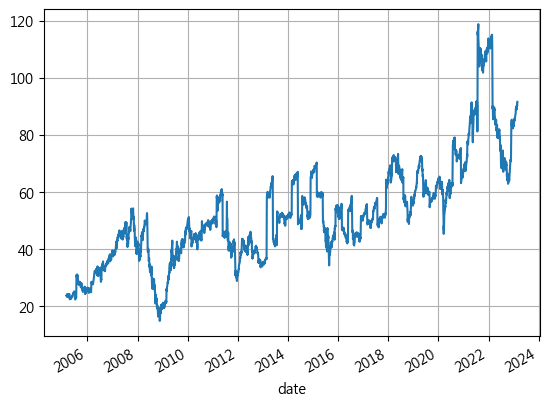

In [12]:
# ---------------------------------------------- 計算排名因子 ----------------------------------------------

# df_sample_pool = df_factor_all_reb[(df_factor_all_reb["market_cap_rank"] > CAP_TOP) & (df_factor_all_reb["market_cap_rank"] <= CAP_BOT)].copy()
df_sample_pool = df_factor_all_reb[
    (df_factor_all_reb["market_cap_rank_full"] > CAP_TOP)
    & (df_factor_all_reb["market_cap_rank_full"] <= CAP_BOT)
].copy()

df_sample_pool["roe_rank"] = df_sample_pool.groupby("date")["roe"].rank(ascending=False)
df_sample_pool["roe_rank_qcut"] = df_sample_pool.groupby("date", group_keys=False)[
    "roe_rank"
].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

df_sample_pool["20_d_return_rank"] = df_sample_pool.groupby("date")["20_d_return"].rank(
    ascending=False
)
df_sample_pool["40_d_return_rank"] = df_sample_pool.groupby("date")["40_d_return"].rank(
    ascending=False
)
df_sample_pool["60_d_return_rank"] = df_sample_pool.groupby("date")["60_d_return"].rank(
    ascending=False
)
df_sample_pool["tobins_q_rank"] = df_sample_pool.groupby("date")["tobins_q"].rank(
    ascending=False
)
df_sample_pool["roe_4q_sum_rank"] = df_sample_pool.groupby("date")["roe_4q_sum"].rank(
    ascending=False
)
df_sample_pool["ni_yoy_rank"] = df_sample_pool.groupby("date")["ni_yoy"].rank(
    ascending=False
)
df_sample_pool["ni_qoq_rank"] = df_sample_pool.groupby("date")["ni_qoq"].rank(
    ascending=False
)

df_sample_pool["ni_yoy_rank_qcut"] = df_sample_pool.groupby("date", group_keys=False)[
    "ni_yoy_rank"
].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

df_sample_pool["meeting_last_year_yield"] = np.where(
    df_sample_pool["last_dividend_yield"] == 0,
    df_sample_pool["dividend_1Y_sum_yield"],
    df_sample_pool["last_dividend_yield"],
)
df_sample_pool["last_dividend_yield_rank"] = df_sample_pool.groupby("date")[
    "last_dividend_yield"
].rank(ascending=False)
df_sample_pool["dividend_1Y_sum_yield_rank"] = df_sample_pool.groupby("date")[
    "dividend_1Y_sum_yield"
].rank(ascending=False)
# df_sample_pool['roe_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['roe_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))
df_sample_pool["ocf / asset_rank"] = df_sample_pool.groupby("date")["ocf / asset"].rank(
    ascending=False
)
df_sample_pool["ocf / asset_rank_qcut"] = df_sample_pool.groupby(
    "date", group_keys=False
)["ocf / asset_rank"].apply(
    lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop")
)

df_sample_pool["rank_sum_1"] = df_sample_pool["roe_rank"]
df_sample_pool["rank_sum_1_rank"] = df_sample_pool.groupby("date")["rank_sum_1"].rank(
    ascending=True
)
df_sample_pool["rank_sum_1_rank_qcut"] = df_sample_pool.groupby(
    "date", group_keys=False
)["rank_sum_1_rank"].apply(
    lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop")
)

df_sample_pool["rank_sum_2"] = (
    df_sample_pool["roe_rank"] + df_sample_pool["60_d_return_rank"]
)
df_sample_pool["rank_sum_2_rank"] = df_sample_pool.groupby("date")["rank_sum_2"].rank(
    ascending=True
)
df_sample_pool["rank_sum_2_rank_qcut"] = df_sample_pool.groupby(
    "date", group_keys=False
)["rank_sum_2_rank"].apply(
    lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop")
)

# df_sample_pool['rank_sum_3'] = df_sample_pool['roe_rank'] + df_sample_pool['60_d_return_rank'] + df_sample_pool['ni_yoy_rank'] + df_sample_pool['ni_qoq_rank']
# df_sample_pool['rank_sum_3'] = df_sample_pool['roe_rank'] + df_sample_pool['60_d_return_rank'] + df_sample_pool['ni_qoq_rank']
df_sample_pool["rank_sum_3"] = (
    df_sample_pool["roe_rank"]
    + df_sample_pool["60_d_return_rank"]
    + df_sample_pool["ni_qoq_rank"]
)
df_sample_pool["rank_sum_3_rank"] = df_sample_pool.groupby("date")["rank_sum_3"].rank(
    ascending=True
)
df_sample_pool["rank_sum_3_rank_qcut"] = df_sample_pool.groupby(
    "date", group_keys=False
)["rank_sum_3_rank"].apply(
    lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop")
)

df_sample_pool["rank_sum_average"] = (
    df_sample_pool["rank_sum_3_rank"] * FACTOR_WEIGHT
    + df_sample_pool["last_dividend_yield_rank"] * LDY_WEIGHT
    + df_sample_pool["dividend_1Y_sum_yield_rank"] * D1Y_WEIGHT
)

df_sample_pool["rank_sum_factor"] = df_sample_pool["rank_sum_3_rank"]

df_sample_pool["rank_sum_dividends"] = (
    df_sample_pool["last_dividend_yield_rank"] * LDY_WEIGHT
    + df_sample_pool["dividend_1Y_sum_yield_rank"] * D1Y_WEIGHT
)

# ---------------------------------------------- 設定流動性篩選 ----------------------------------------------

df_temp = pd.merge(df_sample_pool, df_price_sub, how="left", on=["date", "ticker"])
df_temp = pd.merge(
    df_temp,
    df_factor_all_amount_rank[["date", "ticker", "amount_rank_20"]],
    how="left",
    on=["date", "ticker"],
)
df_temp = df_temp.dropna()

df_temp["cond1"] = df_temp["amount_rank_20"] < 0.25
df_temp["cond2"] = df_temp["20_d_mean_amount_k"] > AMOUNT_FLOOR * 1000
df_temp["cond3"] = df_temp["60_d_median_amount_k"] > AMOUNT_FLOOR * 1000
df_temp["cond4"] = df_temp["20_d_median_amount_k"] > AMOUNT_FLOOR * 1000
df_temp["cond5"] = df_temp["20_d_median_amount_k"] > AMOUNT_FLOOR * 1000
df_temp["cond6"] = df_temp["60_d_median_amount_k"] > AMOUNT_FLOOR * 1000

df_liq_pool = df_temp[
    (df_temp["cond5"] == True) & (df_temp["cond3"] == True) & (df_temp["cond1"] == True)
].copy()
df_liq_pool_for_exist = df_temp[
    (df_temp["cond6"] == True) & (df_temp["cond4"] == True) & (df_temp["cond1"] == True)
].copy()

print("最小檔數: ", df_liq_pool.groupby("date")["ticker"].count().min())

# ---------------------------------------------- 取得再平衡股票清單 ----------------------------------------------
print("取得再平衡股票清單...")

df_factor_all = df_factor_all.dropna(subset=["rebalance_date"]).copy()
reb_lst = df_factor_all["rebalance_date"].unique()

sort_column = "rank_sum_average"
apply_restrict_index = 0
base_portfolio_number = N
restrict_turnover = 10 / 100
remain_number = int(np.ceil(base_portfolio_number * (1 - restrict_turnover)))
# round up the restrict_portfolio_number
restrict_portfolio_number = base_portfolio_number * 2 - remain_number
df_select_pool = df_liq_pool.reset_index(drop=True)
df_select_pool_for_exist = df_liq_pool_for_exist.reset_index(drop=True)
# get the base portfolio by base_portfolio_number
df_select_pool_base = (
    df_select_pool.groupby("date")
    .apply(top_n, n=base_portfolio_number, columns=[sort_column], ascending=[True])
    .reset_index(drop=True)
)
# get the restrict portfolio by restrict_portfolio_number
df_select_pool_restrict = df_select_pool
df_select_pool_restrict.reset_index(drop=True, inplace=True)
df_select_pool_restrict_for_exist = df_select_pool_for_exist.reset_index(drop=True)

apply_restrict_date = np.sort(reb_lst)[apply_restrict_index]
# string format
apply_restrict_date = pd.to_datetime(apply_restrict_date).strftime("%Y-%m-%d")

df_restrict_result = pd.DataFrame([])
# concat the data that date is smaller than apply_restrict_date to df_restrict_result
df_restrict_result = pd.concat(
    [
        df_restrict_result,
        df_select_pool_base[df_select_pool_base["date"] < apply_restrict_date],
    ],
    axis=0,
)
# print the max date in df_restrict_result

for i in range(apply_restrict_index, len(reb_lst)):
    
    # get the month of reb_lst[i]
    month = reb_lst[i].month

    apply_restrict_index = 0
    base_portfolio_number = N
    SORTING_COL = SORTING_DICT[str(month)]
    restrict_turnover = TURNOVER_DICT[str(month)] / 100
    remain_number = int(np.ceil(base_portfolio_number * (1 - restrict_turnover)))
    # round up the restrict_portfolio_number
    restrict_portfolio_number = base_portfolio_number * 2 - remain_number

    # get the slice data by reb_lst[i] in df_select_pool_restrict
    df_select_pool_restrict_temp = df_select_pool_restrict[
        df_select_pool_restrict["rebalance_date"] == reb_lst[i]
    ].reset_index(drop=True)
    df_select_pool_restrict_temp_for_exist = df_select_pool_restrict_for_exist[
        df_select_pool_restrict_for_exist["rebalance_date"] == reb_lst[i]
    ].reset_index(drop=True)

    # get the slice data by reb_lst[i-1] in df_restrict_result, [i-1] is because we need to get the last portfolio
    df_restrict_result_temp = df_restrict_result[
        df_restrict_result["rebalance_date"] == reb_lst[i - 1]
    ].reset_index(drop=True)

    # prepare the dataframe for finding the joint ticker
    df_new_temp = df_select_pool_restrict_temp[
        ["date", "ticker", SORTING_COL]
    ].copy()
    df_new_temp["restrict"] = 1
    df_new_temp.sort_values(
        [SORTING_COL], ascending=True, inplace=True
    )
    df_new_temp.reset_index(drop=True, inplace=True)

    last_portfolio_ticker_list = df_restrict_result_temp["ticker"].unique()

    # df_priority_temp = df_select_pool_restrict_temp[df_select_pool_restrict_temp['ticker'].isin(last_portfolio_ticker_list)].copy()
    df_priority_temp = df_select_pool_restrict_temp_for_exist[
        df_select_pool_restrict_temp_for_exist["ticker"].isin(
            last_portfolio_ticker_list
        )
    ].copy()
    
    df_priority_temp.sort_values(
        [SORTING_COL], ascending=True, inplace=True
    )
    df_priority_temp.reset_index(drop=True, inplace=True)
    df_priority = df_priority_temp.head(remain_number)

    df_added = (
        df_new_temp[df_new_temp["ticker"].isin(df_priority["ticker"].unique()) == False]
        .head(base_portfolio_number - len(df_priority))
        .reset_index(drop=True)
    )
    df_triviality = df_select_pool_restrict_temp[
        df_select_pool_restrict_temp["ticker"].isin(df_added["ticker"].unique())
    ].reset_index(drop=True)

    df_restrict_result_temp = pd.concat([df_priority, df_triviality], axis=0)

    # concat the df_restrict_result_temp to df_restrict_result
    df_restrict_result = pd.concat(
        [df_restrict_result, df_restrict_result_temp], axis=0
    )

df_restrict_result.reset_index(drop=True, inplace=True)
# df_restrict_result_return = df_restrict_result.groupby('date')['y'].mean()
df_restrict_result_return = df_restrict_result.groupby("date")[
    "rebalance_period_return"
].mean()
df_restrict_result["rank_sum_average_rank"] = df_restrict_result.groupby("date")[
    "rank_sum_average"
].rank(ascending=True)

# ---------------------------------------------- 使用再平衡清單回測 - TR ----------------------------------------------
print("使用再平衡清單回測 Total Return...")

df_adjusted_price_for_backtest = df_adjusted_price.copy()
df_adjusted_price_for_backtest.columns = ["date", "ticker", "price"]

(
    df_portfolio_value_all,
    df_portfolio_value_detail_start,
    df_portfolio_value_detail_end,
    df_portfolio_value_detail_all,
    df_portfolio_weight_all
) = get_daily_portfolio_multi_sorting(
    df_restrict_result,
    reb_lst,
    df_adjusted_price_for_backtest,
    "vw",
    **ADJUST_WEIGHTS_PARAMS,
    weight_by_yields=WEIGHT_BY_YIELDS,
    replace_bottom="min",
)


# ---------------------------------------------- 績效評核 - TR ----------------------------------------------

df_compare_portfolio = df_portfolio_value_all.copy()
df_compare_portfolio.columns = ["date", "portfolio_value"]

print("績效評核 - TR...")

df_benchmarks_all = pd.read_excel("./data/benchmarks.xlsx")
df_benchmarks_all.columns = ["日期", "TWA02", "TWA00"]
benchmark_list = df_benchmarks_all.columns.to_list()
benchmark_list.remove("日期")

index_name = benchmark_list[0]
df_benchmarks_temp = df_benchmarks_all[["日期", f"{index_name}"]].copy()
df_benchmarks_temp.columns = ["date", f"{index_name}"]
df_benchmarks_temp.dropna(inplace=True)
# change the date format to datetime
df_benchmarks_temp["date"] = pd.to_datetime(
    df_benchmarks_temp["date"], format="%Y/%m/%d"
)
df_benchmarks_temp.sort_values("date", inplace=True)
df_benchmarks = (
    df_benchmarks_temp.merge(df_compare_portfolio, on="date", how="left")
    .dropna()
    .copy()
)
df_benchmarks.reset_index(drop=True, inplace=True)
df_benchmarks.drop_duplicates(inplace=True)

# df_benchmarks = df_benchmarks[df_benchmarks['date']> '2018-08-01']
# scale the benchmark and portfolio value to 1
df_benchmarks[f"{index_name}_scale"] = (
    df_benchmarks[f"{index_name}"] / df_benchmarks[f"{index_name}"].iloc[0]
)
df_benchmarks["portfolio_value_scale"] = (
    df_benchmarks["portfolio_value"] / df_benchmarks["portfolio_value"].iloc[0]
)

df_benchmarks.set_index("date", inplace=True)

df_benchmarks["portfolio_value_rt"] = df_benchmarks[
    "portfolio_value_scale"
].pct_change()
df_benchmarks[f"{index_name}_rt"] = df_benchmarks[f"{index_name}_scale"].pct_change()

# calculate the beta of portfolio and benchmark
beta = (
    df_benchmarks[["portfolio_value_rt", f"{index_name}_rt"]].cov().iloc[0, 1]
    / df_benchmarks[f"{index_name}_rt"].var()
)
print(f"beta: {beta:.2f}")

# calculate the alpha of portfolio and benchmark
alpha = (
    df_benchmarks[["portfolio_value_rt", f"{index_name}_rt"]].mean().iloc[0]
    - beta * df_benchmarks[f"{index_name}_rt"].mean()
)
# annualized the alpha
ann_alpha = (1 + alpha) ** 252 - 1
print(f"alpha TR: {ann_alpha:.2%}")

df_benchmarks["year"] = df_benchmarks.index.year
df_benchmarks["month"] = df_benchmarks.index.month
df_benchmarks["quarter"] = df_benchmarks.index.quarter

last_values = (
    df_benchmarks.groupby(["year", "month"])
    .tail(1)[[f"{index_name}", "portfolio_value_scale"]]
    .values
)
first_values = (
    df_benchmarks.groupby(["year", "month"])
    .head(1)[[f"{index_name}", "portfolio_value_scale"]]
    .values
)
df_monthly_return = pd.DataFrame(last_values / first_values)

df_monthly_return.columns = [f"{index_name}", "portfolio_value_scale"]
# drop the last row
df_monthly_return = df_monthly_return[:-1]
df_monthly_return["win_rate"] = np.where(
    df_monthly_return["portfolio_value_scale"] > df_monthly_return[f"{index_name}"],
    1,
    0,
)

df_monthly_return["portfolio_rt"] = df_monthly_return[
    "portfolio_value_scale"
].pct_change()
df_monthly_return[f"{index_name}_rt"] = df_monthly_return[f"{index_name}"].pct_change()
last_values = (
    df_benchmarks.groupby(["year", "month"])
    .tail(1)[[f"{index_name}", "portfolio_value_scale"]]
    .values
)
first_values = (
    df_benchmarks.groupby(["year", "month"])
    .head(1)[[f"{index_name}", "portfolio_value_scale"]]
    .values
)

df_quarterly_return = pd.DataFrame(last_values / first_values)
df_quarterly_return.columns = [f"{index_name}", "portfolio_value_scale"]
df_quarterly_return["win_rate"] = np.where(
    df_quarterly_return["portfolio_value_scale"] > df_quarterly_return[f"{index_name}"],
    1,
    0,
)
last_values = (
    df_benchmarks.groupby(["year"])
    .tail(1)[[f"{index_name}", "portfolio_value_scale"]]
    .values
)
first_values = (
    df_benchmarks.groupby(["year"])
    .head(1)[[f"{index_name}", "portfolio_value_scale"]]
    .values
)
df_yearly_return = pd.DataFrame(last_values / first_values)
df_yearly_return.columns = [f"{index_name}", "portfolio_value_scale"]

df_yearly_return["win_rate"] = np.where(
    df_yearly_return["portfolio_value_scale"] > df_yearly_return[f"{index_name}"], 1, 0
)
# create a list from 2005 to 2023 for year column for df_yearly_return
year_list = list(range(2005, len(df_yearly_return) + 2005))
df_yearly_return["year"] = year_list

df_yearly_return[["portfolio_value_scale", f"{index_name}"]] = (
    df_yearly_return[["portfolio_value_scale", f"{index_name}"]] - 1
)

df_benchmarks_temp.reset_index(inplace=True, drop=True)
df_benchmarks_temp.set_index("date", inplace=True)


# series_cagr = calculate_cagr(df_benchmarks[df_benchmarks.index > '2007-06-21'])[:3]
series_cagr = calculate_cagr(df_benchmarks)[:2]
series_sr = calc_sharpe_ratio(df_benchmarks)[:2]


# ---------------------------------------------- 計算 股數殖利率 ----------------------------------------------
print("計算股數殖利率...")

select_ticker = df_restrict_result["ticker"].unique()
df_cash_dividends = pd.read_feather("data/tej_cash_dividends.feather")
df_cash_dividends = ut.tej_data_clean_up(df_cash_dividends)
df_cash_dividends = df_cash_dividends[["股票代號", "除息日", "息值(元)"]].copy()
df_cash_dividends.columns = ["ticker", "date", "dividend"]
df_cash_dividends = df_cash_dividends[
    df_cash_dividends["ticker"].isin(select_ticker)
].copy()
df_cash_dividends.drop_duplicates(inplace=True)
df_cash_dividends["dividend"] = df_cash_dividends["dividend"].astype(float)
df_cash_dividends = df_cash_dividends.groupby(["ticker", "date"]).sum().reset_index()

df_factor_all_price = pd.merge(
    df_factor_all_select, df_price_div, on=["date", "ticker"], how="left"
)
df_factor_all_price_dividend = pd.merge(
    df_factor_all_price, df_cash_dividends, on=["date", "ticker"], how="left"
)
df_factor_all_price_dividend["unadj_yield"] = (
    df_factor_all_price_dividend["dividend"]
    / df_factor_all_price_dividend["yesterday_price"]
)

# calculate the sum of dividend yield of each stock in each period
df_period_yield = df_factor_all_price_dividend.groupby(
    ["ticker", "rebalance_date"], as_index=False, group_keys=False
)["unadj_yield"].sum()

# merge the sum of dividend yield to df_dividend_select for calculate the portfolio dividend yield
df_dividend_select_yield = pd.merge(
    df_portfolio_weight_all, df_period_yield, on=["ticker", "rebalance_date"], how="left"
)

turnover_ratio_lst = []

for i in range(1, len(reb_lst) - 1):
    df_start_temp = df_portfolio_value_detail_start[
        df_portfolio_value_detail_start["date"].isin([reb_lst[i]])
    ]
    df_end_temp = df_portfolio_value_detail_end[
        df_portfolio_value_detail_end["date"].isin([reb_lst[i]])
    ]
    df_rebalance_temp = pd.merge(
        df_start_temp,
        df_end_temp,
        on=["date", "ticker"],
        how="outer",
        suffixes=("_start", "_end"),
    ).fillna(0)
    df_rebalance_temp["turnover"] = abs(
        df_rebalance_temp["value_end"] - df_rebalance_temp["value_start"]
    )
    turnover_ratio = (
        (df_rebalance_temp["turnover"].sum() / df_start_temp["value"].sum()) / 2 * 100
    )
    turnover_ratio_lst.append(turnover_ratio)

# create a dataframe to store the turnover ratio with the rebalance date
df_quarterly_turnover = pd.DataFrame(
    {"date": reb_lst[1:-1], "turnover": turnover_ratio_lst}
).dropna()

df_quarterly_turnover["year"] = df_quarterly_turnover["date"].dt.year
df_quarterly_turnover["quarter"] = df_quarterly_turnover["date"].dt.quarter
df_yearly_turnover = (
    df_quarterly_turnover.groupby("year")["turnover"].mean() * len(REB_MONTH)
).reset_index()

print("平均年化周轉率: ", df_yearly_turnover["turnover"].mean().round(2))
# df_yearly_turnover = df_quarterly_turnover.groupby('quarter')['turnover'].mean().reset_index()
df_turnover = df_yearly_turnover["turnover"].describe().reset_index()
df_turnover.columns = ["index_name", "一般版"]

if WEIGHT_BY_YIELDS:
    use_weight = "weight_by_yields"
else:
    use_weight = "adjusted_weight"


df_dividend_select_yield["weighted_yield"] = (
    df_dividend_select_yield["unadj_yield"]
    * df_dividend_select_yield[use_weight]
)

df_weighted_dividends = df_dividend_select_yield[
    df_dividend_select_yield["weighted_yield"] > 0
][["date", "ticker", use_weight, "weighted_yield"]].copy()

df_quarterly_div = (
    df_dividend_select_yield.groupby("date")["weighted_yield"].sum().reset_index()
)
df_quarterly_div["year"] = df_quarterly_div["date"].dt.year
print(
    "平均每年殖利率",
    round(
        df_quarterly_div.groupby("year")["weighted_yield"].sum().mean().round(4) * 100,
        2,
    ),
)



# # ---------------------------------------------- 計算PR殖利率 ----------------------------------------------
# print("計算PR殖利率...")

df_reb_map = pd.DataFrame([])
df_reb_map["date"] = df_portfolio_value_detail_start["date"].unique()
df_reb_map["date_end"] = df_portfolio_value_detail_end["date"].unique()

df_dividends_value = pd.merge(
    df_weighted_dividends, df_benchmarks.reset_index()[["date", "portfolio_value"]]
)
df_dividends_value["dividends_value"] = (
    df_dividends_value["portfolio_value"] * df_dividends_value["weighted_yield"]
)

df_dividends_adjustment = pd.merge(
    df_portfolio_value_detail_start,
    df_dividends_value[["date", "ticker", "dividends_value"]],
    how="left",
    on=["date", "ticker"],
).fillna(0)
total_value = df_dividends_adjustment.groupby("date")["value"].transform("sum")
df_dividends_adjustment["weight"] = df_dividends_adjustment["value"] / total_value
df_dividends_adjustment = pd.merge(df_dividends_adjustment, df_reb_map, on="date")
df_dividends_adjustment = pd.merge(
    df_dividends_adjustment,
    df_portfolio_value_detail_end,
    how="left",
    left_on=["date_end", "ticker"],
    right_on=["date", "ticker"],
).fillna(0)
# Compute the total value for each date

# Compute the weight of each ticker by dividing its value by the total value for its date
df_dividends_adjustment["last_value_ex_div"] = (
    df_dividends_adjustment["value_y"] - df_dividends_adjustment["dividends_value"]
)
df_dividends_adjustment["price_return"] = (
    df_dividends_adjustment["last_value_ex_div"] / df_dividends_adjustment["value_x"]
    - 1
) * df_dividends_adjustment["weight"]
df_dividends_adjustment["total_return"] = (
    df_dividends_adjustment["value_y"] / df_dividends_adjustment["value_x"] - 1
) * df_dividends_adjustment["weight"]
df_tr_pr = pd.merge(
    df_dividends_adjustment.groupby(["date_x"])["total_return"].sum().reset_index(),
    df_dividends_adjustment.groupby(["date_x"])["price_return"].sum(),
    on="date_x",
)
# change column name date_x to date
df_tr_pr = df_tr_pr.rename(columns={"date_x": "date"})

# add 1 to the return
df_tr_pr["total_return"] = df_tr_pr["total_return"] + 1
df_tr_pr["price_return"] = df_tr_pr["price_return"] + 1

# subtract year from date
df_tr_pr["year"] = df_tr_pr["date"].dt.year

# group by year and multiply the returns
df_tr_year = df_tr_pr.groupby("year")["total_return"].prod().reset_index()
df_pr_year = df_tr_pr.groupby("year")["price_return"].prod().reset_index()

# merge the two dataframes
df_tr_pr_year = pd.merge(df_tr_year, df_pr_year, on="year")
df_tr_pr_year["dividend"] = (
    df_tr_pr_year["total_return"] - df_tr_pr_year["price_return"]
)
df_tr_pr_year.index = df_tr_year["year"]

df_benchmarks_all = pd.read_excel("./data/benchmarks.xlsx")
df_benchmarks_all.columns = ["日期", "TWA02", "TWA00"]

print("近五年指數股息率: ")
print(round(df_tr_pr_year["dividend"].tail(5) * 100, 2))
print("近五年指數平均股息率: ", round(df_tr_pr_year["dividend"].tail(5).mean() * 100, 2))
print("近 5 年 PR 指數累計報酬: ", round(df_tr_pr_year["price_return"].tail(5).prod() * 100, 2))
print(
    "近 5 年 加權 PR 指數累計報酬: ",
    df_benchmarks_all[df_benchmarks_all["日期"] == "2023/03/01"]["TWA00"].values
    / df_benchmarks_all[df_benchmarks_all["日期"] == "2018/02/27"]["TWA00"].values,
)
print("近 5 年 TR 指數累計報酬: ", round(df_tr_pr_year["total_return"].tail(5).prod() * 100, 2))
print(
    "近 5 年 加權 PR 指數累計報酬: ",
    df_benchmarks_all[df_benchmarks_all["日期"] == "2023/03/01"]["TWA02"].values
    / df_benchmarks_all[df_benchmarks_all["日期"] == "2018/02/27"]["TWA02"].values,
)
print("近 8 年 TR 指數累計報酬: ", round(df_tr_pr_year["total_return"].tail(8).prod() * 100, 2))
print(
    "近 8 年 加權 PR 指數累計報酬: ",
    df_benchmarks_all[df_benchmarks_all["日期"] == "2023/03/01"]["TWA02"].values
    / df_benchmarks_all[df_benchmarks_all["日期"] == "2015/02/26"]["TWA02"].values,
)


df_quarterly_div["year"] = df_quarterly_div["date"].dt.year

mean_div = round(
    df_quarterly_div.groupby("year")["weighted_yield"].sum().mean() * 100, 2
)


df_weight_detail = (
    df_portfolio_value_detail_all.sort_values(["date", "ticker"])
    .reset_index(drop=True)
    .copy()
)

# Compute the total value for each date
total_value = df_weight_detail.groupby("date")["value"].transform("sum")

# Compute the weight of each ticker by dividing its value by the total value for its date
df_weight_detail["weight"] = df_weight_detail["value"] / total_value

df_top_5_weighting = (
    df_weight_detail.sort_values(["date", "weight"], ascending=False)
    .groupby("date")
    .head(5)
    .copy()
)
df_top_5_weighting = df_top_5_weighting.groupby("date")["weight"].sum().reset_index()
print(
    "前5檔最大總和權重",
    df_top_5_weighting.max()["date"],
    round(df_top_5_weighting.max()["weight"], 4),
)

df_market_cap_copy = df_factor_all[["date", "ticker", "market_cap"]].copy()

df_weight_detail = pd.merge(
    df_weight_detail, df_market_cap_copy, on=["date", "ticker"], how="left"
).copy()

df_weight_detail["max_aum_assumption"] = (
    df_weight_detail["market_cap"] * 0.1 / df_weight_detail["weight"] / 1000000
)
df_weight_detail[df_weight_detail["date"].isin(reb_lst) == False].groupby("date")[
    "max_aum_assumption"
].min().plot()

plt.grid()

df_df_weight_detail_min = (
    df_weight_detail[df_weight_detail["date"].isin(reb_lst) == False]
    .groupby("date")["max_aum_assumption"]
    .min()
    .reset_index()
)

df_normal_day = (
    df_portfolio_value_detail_all[
        df_portfolio_value_detail_all["date"].isin(reb_lst) == False
    ]
    .sort_values(["date", "ticker"])
    .reset_index(drop=True)
    .copy()
)
df_normal_day = df_normal_day[df_normal_day["date"] > "2018-01-01"]
# Compute the total value for each date
total_value = df_normal_day.groupby("date")["value"].transform("sum")

# Compute the weight of each ticker by dividing its value by the total value for its date
df_normal_day["weight"] = df_normal_day["value"] / total_value
df_amount = df_price[["日期", "股票代號", "成交金額(千)"]]
df_amount.columns = ["date", "ticker", "amount"]

df_normal_day = (
    pd.merge(df_normal_day, df_amount, how="left", on=["date", "ticker"])
    .dropna()
    .reset_index(drop=True)
)
df_normal_day["amount"] = df_normal_day["amount"].astype(int)
df_normal_day = df_normal_day[df_normal_day["amount"] != 0]
df_normal_day["amount_assumption"] = (
    df_normal_day["amount"] * 0.5 / df_normal_day["weight"]
)
df_normal_day.sort_values(["date", "amount_assumption"], inplace=True)
df_normal_day = df_normal_day.merge(
    df_factor_all_amount_rank[["date", "ticker", "amount_rank_20"]],
    how="left",
    on=["date", "ticker"],
)
df_normal_day.groupby("date")["amount_assumption"].min().mean()


# merge the sum of dividend yield to df_dividend_select for calculate the portfolio dividend yield
df_dividend_select_yield = pd.merge(df_restrict_result,df_period_yield,on=['ticker','rebalance_date'],how='left')
# create the weight column for each ticker, weight = 1 / total num of ticker in the rebalance date
df_dividend_select_yield['weight'] = 1 / df_dividend_select_yield.groupby('rebalance_date')['ticker'].transform('count')

df_weight = pd.pivot(df_dividend_select_yield, index='rebalance_date', columns='ticker', values='weight').copy()
df_weight.fillna(0,inplace=True)

# calculate the turnover by calculate the abs change of weight and sum up
df_weight_change = df_weight.diff().abs() / 2 * 100
df_quarterly_turnover = df_weight_change.sum(axis=1).reset_index()
df_quarterly_turnover.columns = ['rebalance_date','turnover']

df_quarterly_turnover['year'] = df_quarterly_turnover['rebalance_date'].dt.year
df_quarterly_turnover['quarter'] = df_quarterly_turnover['rebalance_date'].dt.quarter
df_yearly_turnover = (df_quarterly_turnover.groupby('year')['turnover'].mean() * len(REB_MONTH)).reset_index()
# df_yearly_turnover = df_quarterly_turnover.groupby('quarter')['turnover'].mean().reset_index()
df_yearly_turnover['turnover'].mean().round(2)






# save the params and result to a dictionary
result_dict = {
    "REB_MONTH": REB_MONTH,
    "CAP_TOP": CAP_TOP,
    "CAP_BOT": CAP_BOT,
    "AMOUNT_FLOOR": AMOUNT_FLOOR,
    "N": N,
    "TURNOVER": TURNOVER,
    "TILTED_NUM": TILTED_NUM,
    "TILTED": TILTED,
    "FACTOR_WEIGHT": FACTOR_WEIGHT,
    "LDY_WEIGHT": LDY_WEIGHT,
    "D1Y_WEIGHT": D1Y_WEIGHT,
    "NUM_CUT": NUM_CUT,
    "WEIGHT_BY_YIELDS": WEIGHT_BY_YIELDS,
    "TURNOVER_DICT": TURNOVER_DICT,
    "SORTING_DICT": SORTING_DICT,
    "WEIGHTING_DICT": WEIGHTING_DICT,
    "ADJUST_WEIGHTS_PARAMS": ADJUST_WEIGHTS_PARAMS,
    "SR_BENCH": round(series_sr[0], 2),
    "SR_PORT": round(series_sr[1], 2),
    "CAGR_BENCH": round(series_cagr[0], 4),
    "CAGR_PORT": round(series_cagr[1], 4),
    "ALPHA": round(ann_alpha, 4),
    "BETA": round(beta, 4),
    "MEAN_DIV": round(mean_div, 4),
    "TURNOVER(%)": round(
        df_turnover[df_turnover["index_name"] == "mean"]["一般版"].values[0], 2
    ),
    "TURNOVER(N)": df_yearly_turnover['turnover'].mean().round(2),
    "PR_DIV_5Y": round(df_tr_pr_year["dividend"].tail(5).mean() * 100, 2),
    "PR_DIV_ALL": round(df_tr_pr_year["dividend"].mean() * 100, 2),
    "CUM_PR_PORT_5Y": round(df_tr_pr_year["price_return"].tail(5).prod() * 100, 2),
    "CUM_PR_PORT_All": round(df_tr_pr_year["price_return"].prod() * 100, 2),
    "CUM_TR_PORT_5Y": round(df_tr_pr_year["total_return"].tail(5).prod() * 100, 2),
    "CUM_TR_PORT_All": round(df_tr_pr_year["total_return"].prod() * 100, 2),
    "TOP_5_WEIGHTING": round(df_top_5_weighting.max()["weight"], 4),
    "MIN_AUM_ASSUMPTION": df_df_weight_detail_min[
        df_df_weight_detail_min["date"] > "2018-01-01"
    ].min()["max_aum_assumption"],
    "MIN_AMOUNT_ASSUMPTION_MEAN": df_normal_day.groupby("date")["amount_assumption"]
    .min()
    .mean(),
    "MIN_AMOUNT_ASSUMPTION_MIN": df_normal_day.groupby("date")["amount_assumption"]
    .min()
    .min(),
}




# # plt.savefig(f'./figs/{params_str}_max_aum_assumption.png', dpi=300)

# # pd.DataFrame([params_dict]).iloc[:,:5].dfi.export(f'./figs/table_{params_str}_1.png')
# # pd.DataFrame([params_dict]).iloc[:,6:10].dfi.export(f'./figs/table_{params_str}_2.png')
# # pd.DataFrame([params_dict]).iloc[:,10:14].dfi.export(f'./figs/table_{params_str}_3.png')
# # pd.DataFrame([params_dict]).iloc[:,14:].dfi.export(f'./figs/table_{params_str}_4.png')

# # # loop the f'./figs/table_{params_str}_1.png' to 4
# # for i in range(1, 5):
# #     ut.crop_index(f'./figs/table_{params_str}_{i}.png')

# # ut.merge_images([f'./figs/table_{params_str}_{i}.png' for i in range(1, 5)], f'./figs/{params_str}_table.png', 10)

# # # delete all the f'./figs/table_{params_str}_{i}.png'
# # for i in range(1, 5):
# #     os.remove(f'./figs/table_{params_str}_{i}.png')

# Store result to excel

In [13]:
df_result_dict = pd.json_normalize(result_dict)

In [14]:
df_result_dict.to_excel(f'./data/quant/backtest/result_dict_{result_dict["ALPHA"]}_{result_dict["MEAN_DIV"]}_{result_dict["TURNOVER(%)"]}_{result_dict["CUM_TR_PORT_All"]}.xlsx')

In [15]:
df_holdings = pd.merge(df_portfolio_weight_all[['date','ticker','rank_sum_average','rank_sum_dividends','adjusted_weight']], df_price[['日期','股票代號','股票名稱']], left_on=['date','ticker'], right_on=['日期','股票代號'], how='left')

In [16]:
df_holdings = pd.merge(df_holdings, df_weighted_dividends[['date','ticker','weighted_yield']], how='left', on=['date','ticker'])

In [17]:
df_holdings.to_excel(f'./data/quant/backtest/holdings_{result_dict["ALPHA"]}_{result_dict["MEAN_DIV"]}_{result_dict["TURNOVER(%)"]}_{result_dict["CUM_TR_PORT_All"]}.xlsx')

In [21]:
df_normal_day[df_normal_day['date'] != '2018-03-31']['amount_assumption'].min()

102951.78137079587

52506.56741922162

In [ ]:
# 排序分數加權權重範例

df_single_day_weight = df_portfolio_weight_all[df_portfolio_weight_all['date'].isin([reb_lst[3]])].sort_values(by=['rank_sum_average'])
# plot the df_single_day_weight by weight with bar
df_single_day_weight.plot.bar(x='ticker', y='adjusted_weight', figsize=(24, 10), fontsize=30, rot=90)
plt.grid()

# plot a horizontal line at 0.025 with dashed line style
plt.axhline(y=0.025, color='#b30b0b', linestyle='dashed')

# change the font size of legend
plt.legend(fontsize=30)

In [ ]:
df_tt = df_portfolio_value_detail_start[df_portfolio_value_detail_start['date'].isin(reb_lst)].groupby('date')['ticker'].count().reset_index()
print(len(df_tt[df_tt['ticker'] <= 39]))

## Plot Yearly Dividends Yield

In [ ]:
df_quarterly_div.groupby('year')['weighted_yield'].sum().plot(kind='bar', figsize=(10, 5))
plt.title('Dividends Yield by Year')
plt.grid()

In [ ]:
import re


def get_trading_window(trading_days, quarterly_dates, direction='both'):
    """
    Get 5 trading days before and/or after each date in quarterly_dates that exists in trading_days.

    Parameters:
    - trading_days (list): List of trading dates
    - quarterly_dates (list): List of quarterly dates
    - direction (str): 'before', 'after', or 'both' (default is 'both')

    Returns:
    - dict: A dictionary where key is the date from quarterly_dates and value is a list of 5 trading days before and/or after.
    """
    
    # result = {}
    result = []
    
    for q_date in quarterly_dates:
        if q_date in trading_days:
            index = trading_days.index(q_date)
            
            before_window = trading_days[max(0, index-5):index] if index >= 5 else trading_days[0:index]
            after_window = trading_days[index+1:index+6] if index+6 <= len(trading_days) else trading_days[index+1:]
            
            if direction == 'before':
                # result[q_date] = before_window
                result.append(before_window)

            elif direction == 'after':
                # result[q_date] = after_window
                result.append(after_window)
            else:
                # result[q_date] = (before_window, after_window)
                result.append(before_window)
                result.append(after_window)
                # result[q_date] = (before_window, after_window)
    
    return result


In [ ]:
date_before_reb = get_trading_window(df_portfolio_value_detail_all['date'].unique().tolist(), reb_lst, 'before')
# flatten the list
date_before_reb = [item for sublist in date_before_reb for item in sublist]

df_rebalance_days_before = df_portfolio_value_detail_all[df_portfolio_value_detail_all['date'].isin(date_before_reb)].sort_values(['date','ticker']).reset_index(drop = True).copy()
df_rebalance_days_before = df_rebalance_days_before[df_rebalance_days_before['date'] > '2018-01-01']
# Compute the total value for each date
total_value = df_rebalance_days_before.groupby('date')['value'].transform('sum')

# Compute the weight of each ticker by dividing its value by the total value fJor its date
df_rebalance_days_before['weight'] = df_rebalance_days_before['value'] / total_value
df_amount = df_price[['日期','股票代號','成交金額(千)']]
df_amount.columns = ['date','ticker','amount']

df_rebalance_days_before = pd.merge(df_rebalance_days_before, df_amount, how='left', on=['date', 'ticker']).dropna().reset_index(drop = True)
df_rebalance_days_before['amount'] = df_rebalance_days_before['amount'].astype(int)
df_rebalance_days_before = df_rebalance_days_before[df_rebalance_days_before['amount'] != 0]

df_rebalance_days_before['reb_amount'] = 20000000 * df_rebalance_days_before['weight'] / 5
df_rebalance_days_before['ratio_assumption'] = df_rebalance_days_before['reb_amount'] / df_rebalance_days_before['amount'] 
df_rebalance_days_before.sort_values(['date','ratio_assumption'], inplace=True)

df_rebalance_days_before.groupby('date')['ratio_assumption'].describe()

In [ ]:
date_after_reb = get_trading_window(df_portfolio_value_detail_all['date'].unique().tolist(), reb_lst, 'after')
# flatten the list
date_after_reb = [item for sublist in date_after_reb for item in sublist]

df_rebalance_days_after = df_portfolio_value_detail_all[df_portfolio_value_detail_all['date'].isin(date_after_reb)].sort_values(['date','ticker']).reset_index(drop = True).copy()
df_rebalance_days_after = df_rebalance_days_after[df_rebalance_days_after['date'] > '2018-01-01']
# Compute the total value for each date
total_value = df_rebalance_days_after.groupby('date')['value'].transform('sum')

# Compute the weight of each ticker by dividing its value by the total value fJor its date
df_rebalance_days_after['weight'] = df_rebalance_days_after['value'] / total_value
df_amount = df_price[['日期','股票代號','成交金額(千)']]
df_amount.columns = ['date','ticker','amount']

df_rebalance_days_after = pd.merge(df_rebalance_days_after, df_amount, how='left', on=['date', 'ticker']).dropna().reset_index(drop = True)
df_rebalance_days_after['amount'] = df_rebalance_days_after['amount'].astype(int)
df_rebalance_days_after = df_rebalance_days_after[df_rebalance_days_after['amount'] != 0]

df_rebalance_days_after['reb_amount'] = 40000000 * df_rebalance_days_after['weight'] / 5
df_rebalance_days_after['ratio_assumption'] = df_rebalance_days_after['reb_amount'] / df_rebalance_days_after['amount'] 
df_rebalance_days_after.sort_values(['date','ratio_assumption'], inplace=True)

df_rebalance_days_after.groupby('date')['ratio_assumption'].describe()

## Test for capability

In [ ]:
df_factor_liq_test = df_factor_all.copy()
df_factor_liq_test['market_cap_rank'] = df_factor_liq_test.groupby('date')['market_cap'].rank(ascending=False)
df_factor_liq_test = df_factor_liq_test[df_factor_liq_test['market_cap_rank'] <= 50]
df_factor_liq_test['weight'] = 0.025
df_factor_liq_test = pd.merge(df_factor_liq_test, df_amount, how='left', on=['date', 'ticker']).dropna().reset_index(drop = True)
df_factor_liq_test['amount'] = df_factor_liq_test['amount'].astype(int)

df_factor_liq_test['reb_amount'] = 40000000 * df_factor_liq_test['weight'] / 5
df_factor_liq_test['ratio_assumption'] = df_factor_liq_test['reb_amount'] / df_factor_liq_test['amount'] 
df_factor_liq_test.sort_values(['date','ratio_assumption'], inplace=True)
df_factor_liq_test = df_factor_liq_test[['date','ticker','ratio_assumption']]
df_factor_liq_test = df_factor_liq_test[df_factor_liq_test['date'] >= '2018-01-01']
# df_factor_liq_test = df_factor_liq_test.merge(df_price_sub[['date','ticker','20_d_mean_amount_k','252_d_mean_amount_k']], on = ['date','ticker'], how = 'left')
df_factor_liq_test.groupby('date')['ratio_assumption'].describe()

In [ ]:
df_00929_holdings = pd.read_excel('./data/00929.xlsx')
df_00929_holdings['日期'] = pd.to_datetime(df_00929_holdings['日期'])
# format 日期 to yyyymmdd as string
df_00929_holdings['日期'] = df_00929_holdings['日期'].dt.strftime('%Y%m%d')
df_00929_holdings = df_00929_holdings[['日期','標的代號','權重(%)']]
df_00929_holdings['標的代號'] = df_00929_holdings['標的代號'].astype(str)
df_00929_holdings = pd.merge(df_00929_holdings,df_new_price, left_on=['日期','標的代號'], right_on=['日期','股票代號'], how = 'left').dropna()
df_00929_holdings = df_00929_holdings[['日期','標的代號','成交金額(千)','權重(%)']]
df_00929_holdings['權重(%)'] = df_00929_holdings['權重(%)'] / 100
df_00929_holdings['amount_assumption'] = df_00929_holdings['成交金額(千)'] * 0.25 / df_00929_holdings['權重(%)']
df_00929_holdings['ratio_assumption'] = 40000000 * df_00929_holdings['權重(%)'] / 5 / df_00929_holdings['成交金額(千)']

In [ ]:
df_00929_holdings['ratio_assumption'].mean()

In [ ]:
df_00929_holdings.groupby('日期')['amount_assumption'].min().describe()

In [ ]:
df_factor_all.to_feather(f'./data/model/{model_folder_name}/df_factor_all_select.feather')
df_factor_all_test = df_factor_all.copy()
df_factor_all_test.sort_values(['date','ticker'], inplace=True)
df_factor_all_test.reset_index(drop=True, inplace=True)
df_factor_all_test['market_cap_billion'] = df_factor_all_test['market_cap'] / 1000000
df_factor_all_test['market_cap_rank'] = df_factor_all_test.groupby('date')['market_cap'].rank(ascending=False)

In [ ]:
# change df_factor_all_test date format to yyyymmdd
df_factor_all_test['date'] = df_factor_all_test['date'].apply(lambda x: x.strftime('%Y%m%d'))

In [ ]:
df_factor_all_test.columns

In [ ]:
df_market_cap_rank = df_factor_all_test[['date','ticker','market_cap_rank']]
df_market_cap_rank = df_market_cap_rank[df_market_cap_rank['date'] == '20230428']

In [ ]:
df_normal_day_00929 = df_00929_holdings.merge(df_market_cap_rank, left_on=['標的代號'], right_on=['ticker'], how='left')

In [ ]:
df_normal_day['amount'].describe()